# Contribution profiles in real networks 

In [1]:
import random
import pickle
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from msb import Balance

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.3,
    palette="deep"
)

# COLORS = np.array(["#7aa063", "#c86b57", "#9d6ebd"])
COLORS = np.array(["#c76674", "#9a9945", "#8961b3"])
RED    = "#f97959"
BLUE   = "#60a1f7"
GRAY   = "#efefef"

# Paths
HERE = Path(".").absolute()
ROOT = HERE.parent
DATA = ROOT/"data"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Balance params
BKWS = dict(m=10, kmin=2)

# Network datasets
LABELS = {
    "new-guinea-tribes":   "Tribes",
    "epinions-trust":      "Epinions",
    "wikipedia-elections": "Wikipedia",
    "slashdot-zoo":        "Slashdot",
}
NETWORKS = {
    name: ig.Graph.Read_GraphMLz(DATA/f"{label}.graphml.gz")
    for label, name in LABELS.items()
}


/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/igraph/io/files.py:189: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return cls.Read_GraphML(tmpfile, index=index)


In [2]:
## MAKE DATA
BALANCE = {}
for name, graph in tqdm(NETWORKS.items()):
    B = Balance(graph, **BKWS)
    BALANCE[name] = (Balance(graph, semi=True), Balance(graph, beta=1, semi=False))


  0%|          | 0/4 [00:00<?, ?it/s]

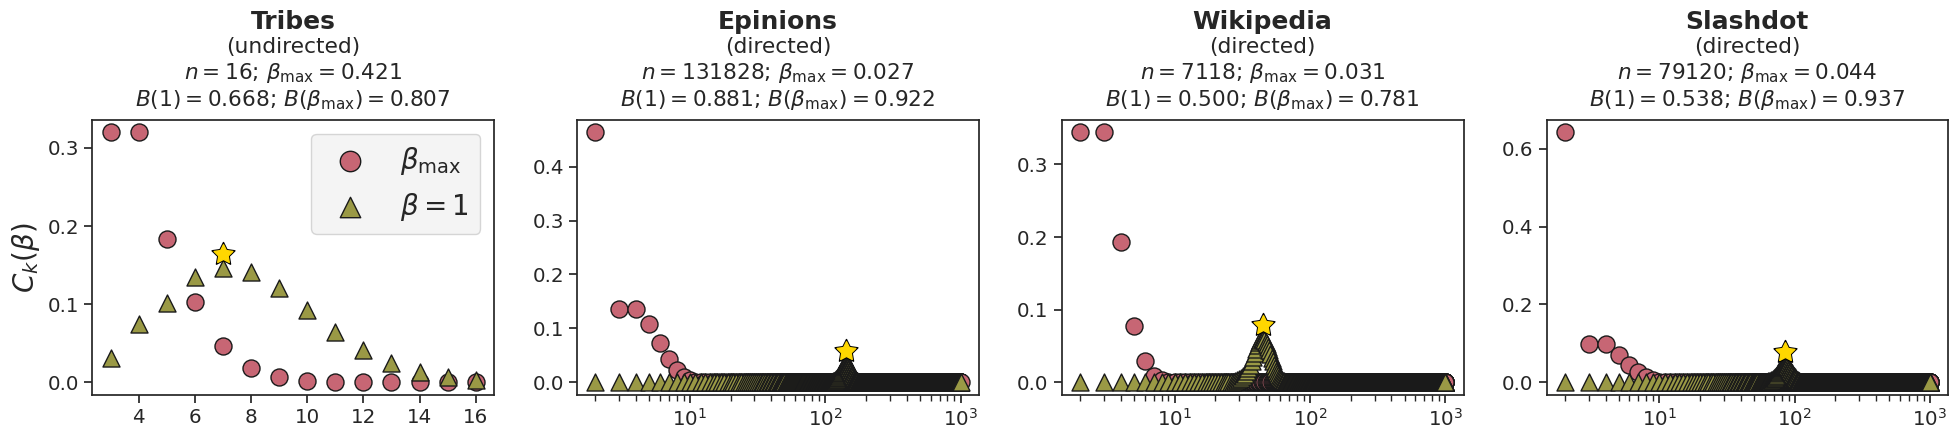

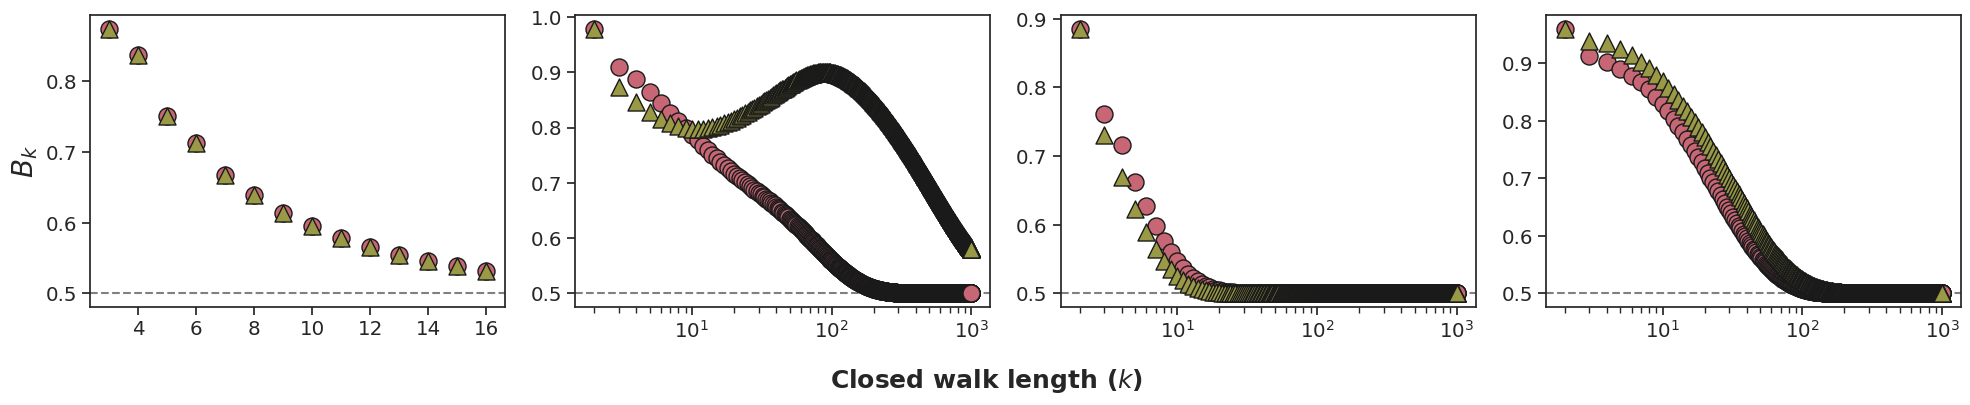

In [3]:
use = (
    "Tribes",
    "Epinions",
    "Wikipedia",
    "Slashdot"
)
balance = { k: v for k, v in BALANCE.items() if use and k in use }

fig1, axes1 = plt.subplots(ncols=len(balance), nrows=1, figsize=(20, 5))
fig2, axes2 = plt.subplots(ncols=len(balance), nrows=1, figsize=(20, 4.3))

for i, kv in enumerate(balance.items()):
    name, B = kv
    B, W = B
    B.set_krange(B.kmin, kmax=1000)
    W.set_krange(W.kmin, kmax=1000)
    C0 = B.contrib().reset_index("beta", drop=True)
    C1 = W.contrib().reset_index("beta", drop=True)
    P1 = B.k_balance()
    P2 = W.k_balance()
    ax = axes1[i]
    skws = dict(s=150, edgecolors="k")
    ax.scatter(C0.index, C0, color=COLORS[0], label=r"$\beta_{\max}$", marker="o", **skws)
    ax.scatter(C1.index, C1, color=COLORS[1], label=r"$\beta = 1$", marker="^", **skws)
    ax.set_title(name, fontweight="bold", fontsize=18, y=1.3)
    dob0 = B.balance()
    dob1 = W.balance()
    info = rf"$n = {B.n_nodes}$; $\beta_{{\max}} = {B.beta:.3f}$"
    dobs = rf"$B(1) = {dob1:.3f}$; $B(\beta_{{\max}}) = {dob0:.3f}$"
    mode = "directed" if B.directed else "undirected"
    ax.annotate(f"({mode})\n{info}\n{dobs}", (.5, 1.05), xycoords="axes fraction", ha="center")

    # Show peak for C1
    y0, y1 = ax.get_ylim()
    kpeak = C1.idxmax()
    peak  = C1.max()+(y1-y0)*.05
    ax.scatter(kpeak, peak, marker=(5,1), s=300, c="black")
    ax.scatter(kpeak, peak, marker=(5,1), s=200, c="gold")

    if name == "Tribes":
        ax.set_ylabel(r"$C_k(\beta)$", fontsize=20)
        ax.legend(fontsize=20, markerscale=1.2, facecolor="#f2f2f2")

    ax = axes2[i]
    ax.scatter(P1.index, P1, color=COLORS[0], marker="o", **skws)
    ax.scatter(P2.index, P2, color=COLORS[1], marker="^", **skws)
    ax.axhline(.5, ls="--", color="gray", zorder=-10)

    if name == "Tribes":
        ax.set_ylabel(r"$B_k$", fontsize=20)

    for ax in [axes1[i], axes2[i]]:
        if B.n_nodes >= 1000:
            ax.set_xscale("log")
        else:
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig2.supxlabel(r"Closed walk length ($k$)", y=.05, fontweight="bold", fontsize=18)
fig1.tight_layout()
fig2.tight_layout()

fig1.savefig(FIGS/"contrib.png", bbox_inches="tight", dpi=300)
fig2.savefig(FIGS/"balance.png", bbox_inches="tight", dpi=300)


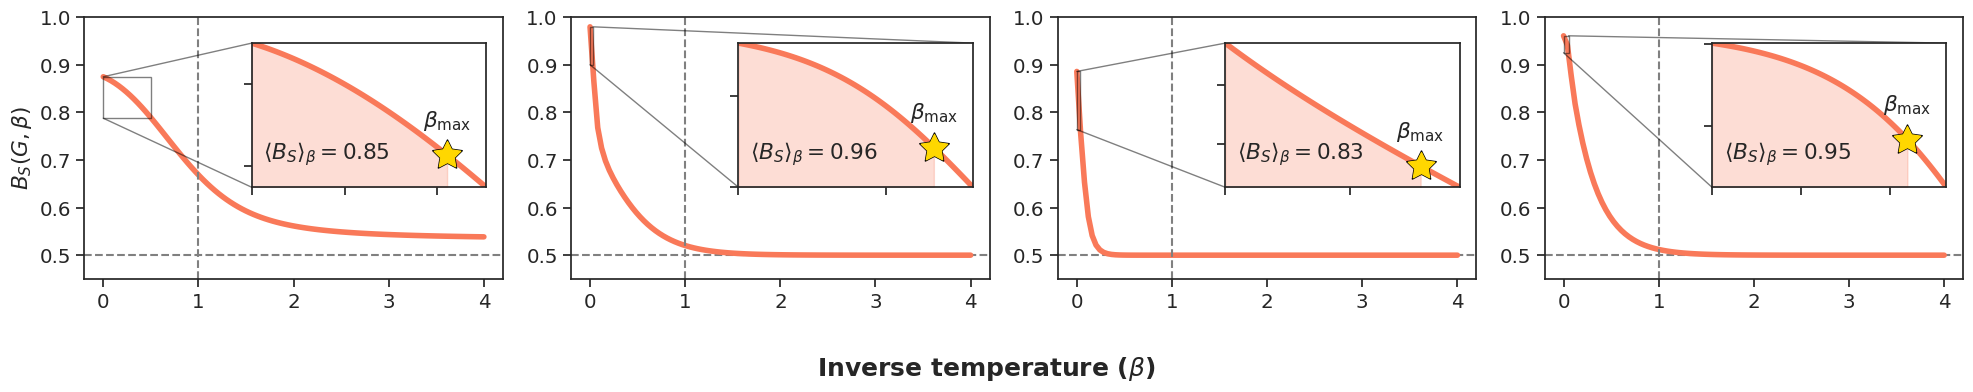

In [4]:
fig, axes = plt.subplots(ncols=len(balance), figsize=(20, 4))

for kv, ax in zip(BALANCE.items(), axes):
    color = RED
    name, B = kv
    B, *_ = B
    bmin = np.finfo(float).eps
    bmax = B.beta
    dob = B.balance(B.B(bmin, 4, 100))
    ax.plot(dob.index, dob, linewidth=4, c=color)
    ax.axhline(.5, ls="--", c="gray", zorder=-10)
    ax.set_ylim(.45, 1)

    # Inset
    bmax *= 1.2
    dob_max = B.balance(bmin)
    dob_min = B.balance(bmax)
    xlim = (0, bmax)
    ylim = (dob_min, dob_max)
    bounds = [.4, .35, .56, .55]
    axin = ax.inset_axes(bounds)
    axin.set_xticklabels([])
    axin.set_yticklabels([])
    axin.set_xlim(*xlim)
    axin.set_ylim(*ylim)
    dob = B.balance(B.B(bmin, bmax, 100))
    axin.plot(dob.index, dob, linewidth=4, c=color)
    ax.indicate_inset_zoom(axin, edgecolor="black")

    # Average
    y0, y1 = ylim
    bmax = B.beta.max()
    dob  = B.balance(B.B(size=100))
    axin.fill_between(dob.index, y0, dob, color=color, alpha=.25)
    adob = dob.mean()
    text = rf"$\langle{{}}B_S\rangle_{{\beta}} = {adob:.2f}$"
    axin.annotate(text, (.05, .2), xycoords="axes fraction", ha="left")
    dob = B.balance()
    axin.scatter(bmax, dob, marker=(5, 1), s=500, c="black", zorder=99)
    axin.scatter(bmax, dob, marker=(5, 1), s=400, c="gold", zorder=99)
    axin.annotate(r"$\beta_{\max}$", (bmax, dob + .2*(y1-y0)), ha="center")

    if name == "Tribes":
        ax.set_ylabel(r"$B_S(G, \beta)$")

    ax.axvline(1, ls="--", color="gray")

fig.supxlabel(r"Inverse temperature ($\beta$)", fontweight="bold", fontsize=18)
fig.tight_layout()

fig.savefig(FIGS/"balance.pdf", bbox_inches="tight")


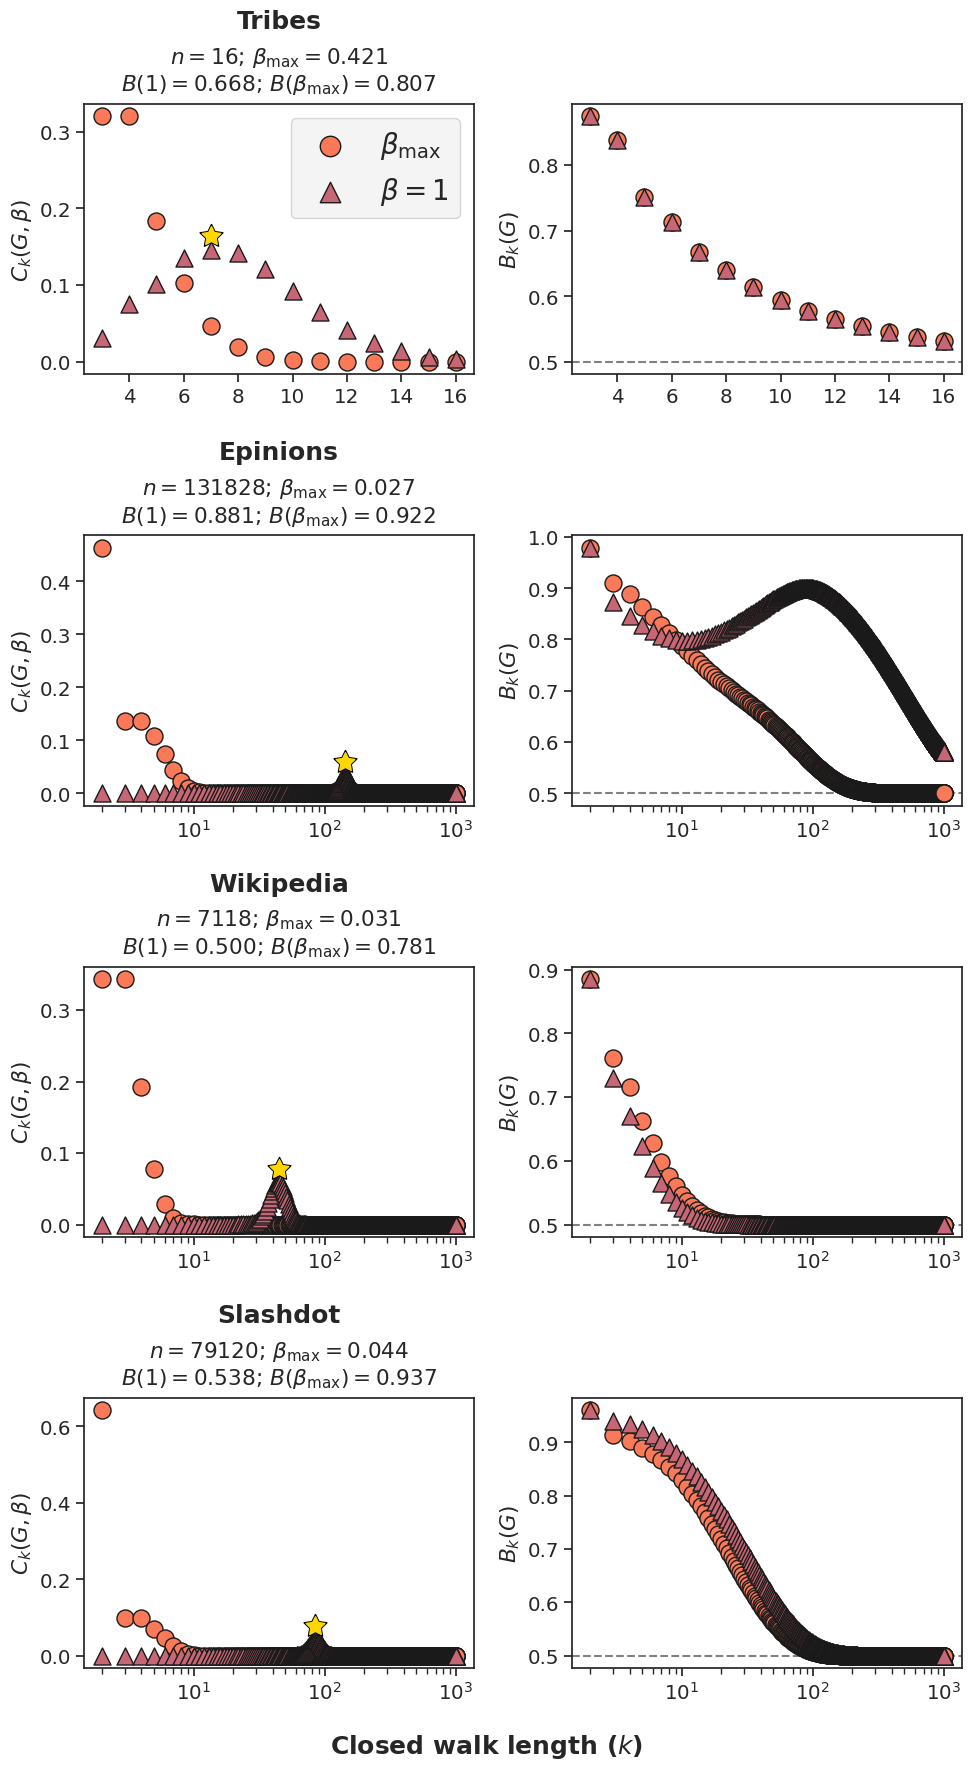

In [5]:
use = (
    "Tribes",
    "Epinions",
    "Wikipedia",
    "Slashdot"
)
balance = { k: v for k, v in BALANCE.items() if use and k in use }

fig, axes = plt.subplots(ncols=2, nrows=len(balance), figsize=(10, 18))

for kv, axrow in zip(balance.items(), axes):
    name, B = kv
    B, W = B
    B.set_krange(B.kmin, kmax=1000)
    W.set_krange(W.kmin, kmax=1000)
    C0 = B.contrib().reset_index("beta", drop=True)
    C1 = W.contrib().reset_index("beta", drop=True)
    P1 = B.k_balance()
    P2 = W.k_balance()
    ax = axrow[0]
    skws = dict(s=150, edgecolors="k")
    ax.scatter(C0.index, C0, color=RED, label=r"$\beta_{\max}$", marker="o", **skws)
    ax.scatter(C1.index, C1, color=COLORS[0], label=r"$\beta = 1$", marker="^", **skws)
    ax.set_title(name, fontweight="bold", fontsize=18, y=1.25)
    dob0 = B.balance()
    dob1 = W.balance()
    info = rf"$n = {B.n_nodes}$; $\beta_{{\max}} = {B.beta:.3f}$"
    dobs = rf"$B(1) = {dob1:.3f}$; $B(\beta_{{\max}}) = {dob0:.3f}$"
    ax.annotate(f"{info}\n{dobs}", (.5, 1.05), xycoords="axes fraction", ha="center")

    # Show peak for C1
    y0, y1 = ax.get_ylim()
    kpeak = C1.idxmax()
    peak  = C1.max()+(y1-y0)*.05
    ax.scatter(kpeak, peak, marker=(5,1), s=300, c="black")
    ax.scatter(kpeak, peak, marker=(5,1), s=200, c="gold")

    if name == "Tribes":
        ax.legend(fontsize=20, markerscale=1.2, facecolor="#f2f2f2")
    ax.set_ylabel(r"$C_k(G, \beta)$")

    ax = axrow[1]
    ax.scatter(P1.index, P1, color=RED, marker="o", **skws)
    ax.scatter(P2.index, P2, color=COLORS[0], marker="^", **skws)
    ax.axhline(.5, ls="--", color="gray", zorder=-10)

    ax.set_ylabel(r"$B_k(G)$")

    for ax in axrow:
        if B.n_nodes >= 1000:
            ax.set_xscale("log")
        else:
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig.supxlabel(r"Closed walk length ($k$)", fontweight="bold", fontsize=18)
fig.tight_layout()

fig.savefig(FIGS/"contrib-alt.png", bbox_inches="tight")
